# Regression with Outliers

In the standard __Gaussian process regression__ setting it is assumed that the observations are __Normally distributed__ about the latent function. In the package this can applied using either the `GP` or `GPE` functions with which *exact Gaussian process* models.

One of the drawbacks of exact GP regression is that by assuming Normal noise the GP is __not robust to outliers__. In this setting, it is more appropriate to assume that the distribution of the noise is heavy tailed. For example, with a __Student-t distribution__,
$$
\mathbf{y} \ | \ \mathbf{f},\nu,\sigma \sim \prod_{i=1}^n \frac{\Gamma(\nu+1)/2}{\Gamma(\nu/2)\sqrt{\nu\pi}\sigma}\left(1+\frac{(y_i-f_i)^2}{\nu\sigma^2}\right)^{-(\nu+1)/2}
$$

Moving away from the Gaussian likelihood function (i.e. Normally distributed noise) and using the Student-t likelihood means that we can no longer analytically calculate the GP marginal likelihood. We can take a Bayesian perspective and sample from the joint distribution of the latent function and model parameters.


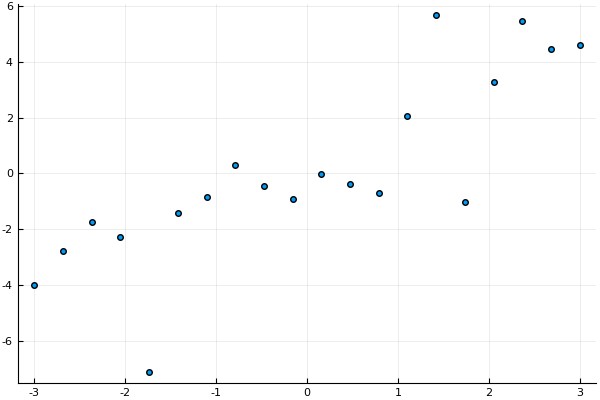

In [1]:
#Load functions from packages
using GaussianProcesses, Plots
using Distributions:Normal, TDist
using Klara:MALA

#Simulate the data
srand(112233)
n = 20
X = collect(linspace(-3,3,n))
sigma = 1.0
Y = X + sigma*rand(TDist(3),n);

# Plots observations
pyplot()
scatter(X,Y;fmt=:png, leg=false)

We fit a standard (exact) Gaussian process model to the Student-t data and compare this against the Monte Carlo GP which is applicable for non-Gaussian observations models.

In [2]:
#Build the models

gpe = GPE(X,vec(Y),MeanZero(),Matern(3/2,0.0,0.0),0.5) #Exact GP assuming Gaussian noise

l = StuTLik(3,0.1)
gpmc = GPMC(X, vec(Y), MeanZero(), Matern(3/2,0.0,0.0), l) #Monte Carlo GP with student-t likelihood

GP Monte Carlo object:
  Dim = 1
  Number of observations = 20
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Float64[]
  Kernel:
    Type: GaussianProcesses.Mat32Iso, Params: [0.0, 0.0]
  Likelihood:
    Type: GaussianProcesses.StuTLik, Params: [0.1]
  Input observations = 
[-3.0 -2.68421 … 2.68421 3.0]
  Output observations = [-3.98707, -2.7855, -1.74722, -2.27384, -7.12662, -1.43191, -0.840899, 0.305618, -0.444213, -0.924319, -0.0303161, -0.368707, -0.706642, 2.07517, 5.68693, -1.02634, 3.25863, 5.46091, 4.45861, 4.60741]
  Log-posterior = -77.863

Estimate the parameters of the exact GP through maximum likelihood estimation

In [3]:
optimize!(gpe)

Dict(:mean=>true,:kern=>true,:noise=>true)


Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.5,0.0,0.0]
 * Minimizer: [0.6566151884189473,1.7118340256787345, ...]
 * Minimum: 4.578633e+01
 * Iterations: 11
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * f(x) > f(x'): false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 46
 * Gradient Calls: 46

Taking a Bayesian perspective, we can add prior distributions to the model parameters and sample from the posterior distribution using Markov chain Monte Carlo through the `mcmc` function. This function builds on the [Klara](https://github.com/JuliaStats/Klara.jl) package and a list of available samplers can be found through this package's documentation.

In [4]:
set_priors!(gpmc.lik,[Normal(-2.0,4.0)])
set_priors!(gpmc.k,[Normal(-2.0,4.0),Normal(-2.0,4.0)])

samples = mcmc(gpmc;sampler=MALA(0.05),nIter=50000, thin=10, burnin=10000)

BasicMCJob:
  Variable [1]: p (BasicContMuvParameter)
  GenericModel: 1 variables, 0 dependencies (directed graph)
  MALA sampler: drift step = 0.05
  VanillaMCTuner: period = 100, verbose = false
  BasicMCRange: number of steps = 49991, burnin = 10000, thinning = 10

23×4000 Array{Float64,2}:
 -1.44975    -1.44975    -1.02479   …  -1.43093    -1.23015   -1.23015 
  0.588195    0.588195    0.332809      1.08002     1.17153    1.17153 
  0.718085    0.718085    0.211443      0.493442    0.385335   0.385335
 -1.32609    -1.32609    -1.15774      -0.333319   -0.200674  -0.200674
 -0.721646   -0.721646   -0.855224     -0.55112    -0.794651  -0.794651
  0.851406    0.851406    0.986268  …   1.32336     1.21235    1.21235 
 -0.250237   -0.250237   -0.296884     -0.298572   -0.166915  -0.166915
  0.154486    0.154486    0.387819      0.0714513   0.162703   0.162703
 -0.0969148  -0.0969148  -0.324955     -0.446952   -0.267948  -0.267948
 -0.380338   -0.380338    0.133223      0.765023    0.42936    0.42936 
  0.378311    0.378311    0.555143  …  -0.226185   -0.211079  -0.211079
 -0.918741   -0.918741   -0.744673     -0.589133   -0.436455  -0.436455
 -0.136525   -0.136525    0.123217      1.7611      1.83721    1.83721 
  1.77061     1.77061     1.61585     


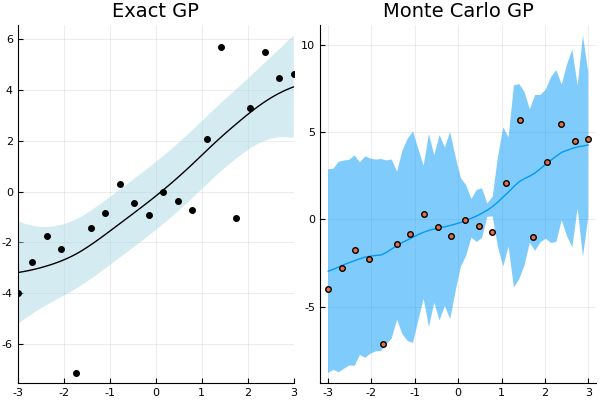

In [5]:
#Plot posterior samples
xtest = linspace(minimum(gpmc.X),maximum(gpmc.X),50);

#Set the parameters to the posterior values the sample random function
fsamples = [];
for i in 1:size(samples,2)
    set_params!(gpmc,samples[:,i])
    update_target!(gpmc)
    push!(fsamples, rand(gpmc,xtest))
end

#Predict
p1=plot(gpe,leg=false, title="Exact GP")   #Exact GP (assuming Gaussian noise)

sd = [std(fsamples[i]) for i in 1:50]
p2=plot(xtest,mean(fsamples),ribbon=2*sd,leg=false, title="Monte Carlo GP") #GP Monte Carlo with student-t noise
scatter!(X,Y)

plot(p1,p2;fmt=:png)